In [1]:
import sys
sys.path.append('..')

In [2]:
from src.models.cnn import SimpleCNN

In [3]:
model = SimpleCNN()
model

SimpleCNN(
  (conv_stack): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
    (5): AdaptiveAvgPool2d(output_size=(3, 3))
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_stack): Sequential(
    (0): Linear(in_features=144, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=5, bias=True)
  )
)

In [4]:
from pathlib import Path
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms


class SpectrogramDataset(Dataset):
    def __init__(self, root_dir: str):
        self.root_dir = Path(root_dir)
        self.classes = sorted(d.name for d in self.root_dir.iterdir() if d.is_dir())
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        
        self.samples = []
        for cls in self.classes:
            for img_path in (self.root_dir / cls).glob("*.png"):
                self.samples.append((img_path, self.class_to_idx[cls]))

        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),  # keeps 600×600
        ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path)
        image = self.transform(image)
        return image, label


In [5]:
from torch.utils.data import DataLoader
import os

cwd = Path(os.getcwd()).parent
dataset = SpectrogramDataset(Path(cwd, "data", "final"))
loader = DataLoader(dataset, batch_size=8, shuffle=True)

X, y = next(iter(loader))
print(X.shape, y.shape)

torch.Size([8, 1, 600, 600]) torch.Size([8])


In [6]:
import torch
from torch.utils.data import random_split

N = len(dataset)

train_size = int(0.6 * N)
val_size = int(0.2 * N)
test_size = N - train_size - val_size  # avoids rounding bugs

In [7]:
generator = torch.Generator().manual_seed(42)

train_ds, val_ds, test_ds = random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=generator
)

In [8]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=8, shuffle=False)


In [9]:
x, y = next(iter(train_loader))
print(x.shape, y.shape)

torch.Size([8, 1, 600, 600]) torch.Size([8])


### Training

In [10]:
## Training the model
from torch import nn, optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [11]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        correct += (logits.argmax(dim=1) == y).sum().item()
        total += y.size(0)

    return running_loss / total, correct / total

In [12]:
@torch.no_grad()
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        loss = criterion(logits, y)

        running_loss += loss.item() * x.size(0)
        correct += (logits.argmax(dim=1) == y).sum().item()
        total += y.size(0)

    return running_loss / total, correct / total


In [13]:
num_epochs = 10
patience = 1
best_val_loss = float("inf")
epochs_without_improvement = 0

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, device
    )

    val_loss, val_acc = validate(
        model, val_loader, criterion, device
    )

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(
        f"Epoch {epoch+1:02d} | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.3f} | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.3f}"
    )

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        best_model_state = model.state_dict()  # optional but smart
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping triggered. Model has stopped learning anything useful.")
            model.load_state_dict(best_model_state)  # restore best model
            break


Epoch 01 | Train Loss: 1.0897, Train Acc: 0.480 | Val Loss: 0.2962, Val Acc: 1.000
Epoch 02 | Train Loss: 0.2685, Train Acc: 0.881 | Val Loss: 0.1732, Val Acc: 1.000
Epoch 03 | Train Loss: 0.1777, Train Acc: 0.929 | Val Loss: 0.1220, Val Acc: 1.000
Epoch 04 | Train Loss: 0.1382, Train Acc: 0.957 | Val Loss: 0.0107, Val Acc: 1.000
Epoch 05 | Train Loss: 0.0025, Train Acc: 1.000 | Val Loss: 0.0009, Val Acc: 1.000
Epoch 06 | Train Loss: 0.0006, Train Acc: 1.000 | Val Loss: 0.0005, Val Acc: 1.000
Epoch 07 | Train Loss: 0.0003, Train Acc: 1.000 | Val Loss: 0.0002, Val Acc: 1.000
Epoch 08 | Train Loss: 0.0002, Train Acc: 1.000 | Val Loss: 0.0002, Val Acc: 1.000
Epoch 09 | Train Loss: 0.0001, Train Acc: 1.000 | Val Loss: 0.0001, Val Acc: 1.000
Epoch 10 | Train Loss: 0.0001, Train Acc: 1.000 | Val Loss: 0.0001, Val Acc: 1.000


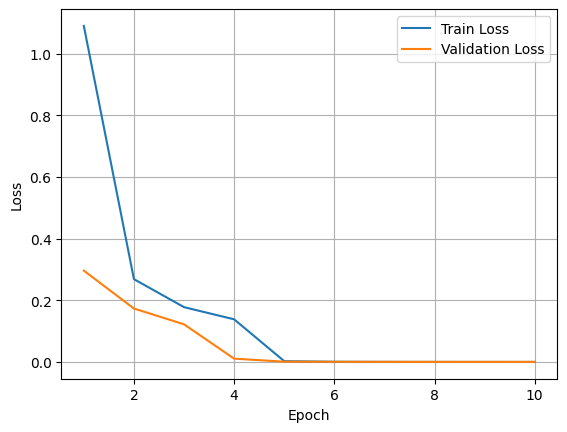

In [15]:
import matplotlib.pyplot as plt
epochs = range(1, len(train_losses) + 1)

plt.figure()
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

### Evaluate

In [16]:
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        preds = logits.argmax(dim=1)

        correct += (preds == y).sum().item()
        total += y.size(0)

        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

    accuracy = correct / total
    return accuracy, torch.cat(all_preds), torch.cat(all_labels)


In [17]:
test_acc, y_pred, y_true = evaluate(model, test_loader, device)

print(f"Test Accuracy: {test_acc:.3f}")

Test Accuracy: 1.000


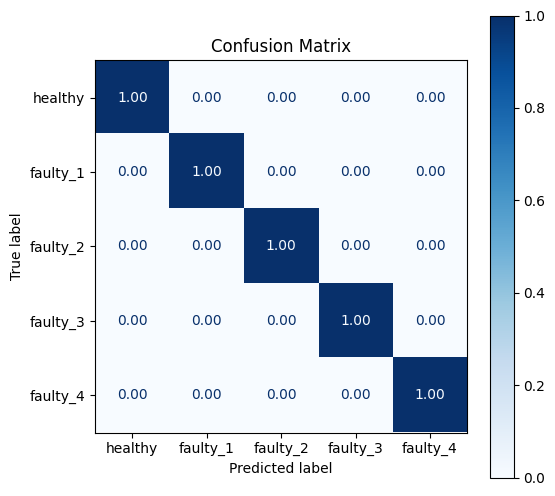

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred, normalize="true")

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["healthy", "faulty_1", "faulty_2", "faulty_3", "faulty_4"]  # list like ["healthy", "faulty_1", ...]
)

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap="Blues", values_format=".2f")
plt.title("Confusion Matrix")
plt.show()

In [21]:
import numpy as np

num_classes = 5
for cls in range(num_classes):
    idx = (y_true == cls)
    acc = (y_pred[idx] == y_true[idx]).float().mean().item()
    print(f"Class {cls} accuracy: {acc:.3f}")


Class 0 accuracy: 1.000
Class 1 accuracy: 1.000
Class 2 accuracy: 1.000
Class 3 accuracy: 1.000
Class 4 accuracy: 1.000


In [22]:
torch.save(model.state_dict(), "model.pth")